In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
from matplotlib import pyplot as plt
from cmocean import cm
%matplotlib inline

from mitequinox.utils import *
from mitequinox.sigp import *

In [2]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='01:00:00')
w = cluster.scale(1*10)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.135.39.10:38268 Dashboard: /user/yux/proxy/8787/status,Cluster Workers: 12 Cores: 12 Memory: 200.04 GB


__________
## 4. 2. spectral comparison 
### $E_{ageo}(\omega, lat)$, $E_{geo}(\omega, lat)$ and $E_{total}(\omega, lat)$

In [5]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ageo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [6]:
v = 'uv'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv//%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_total_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [7]:
v = 'uv_geo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_geo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [8]:
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_total_zav.latitude))
f_cpd = f*86400/2./np.pi

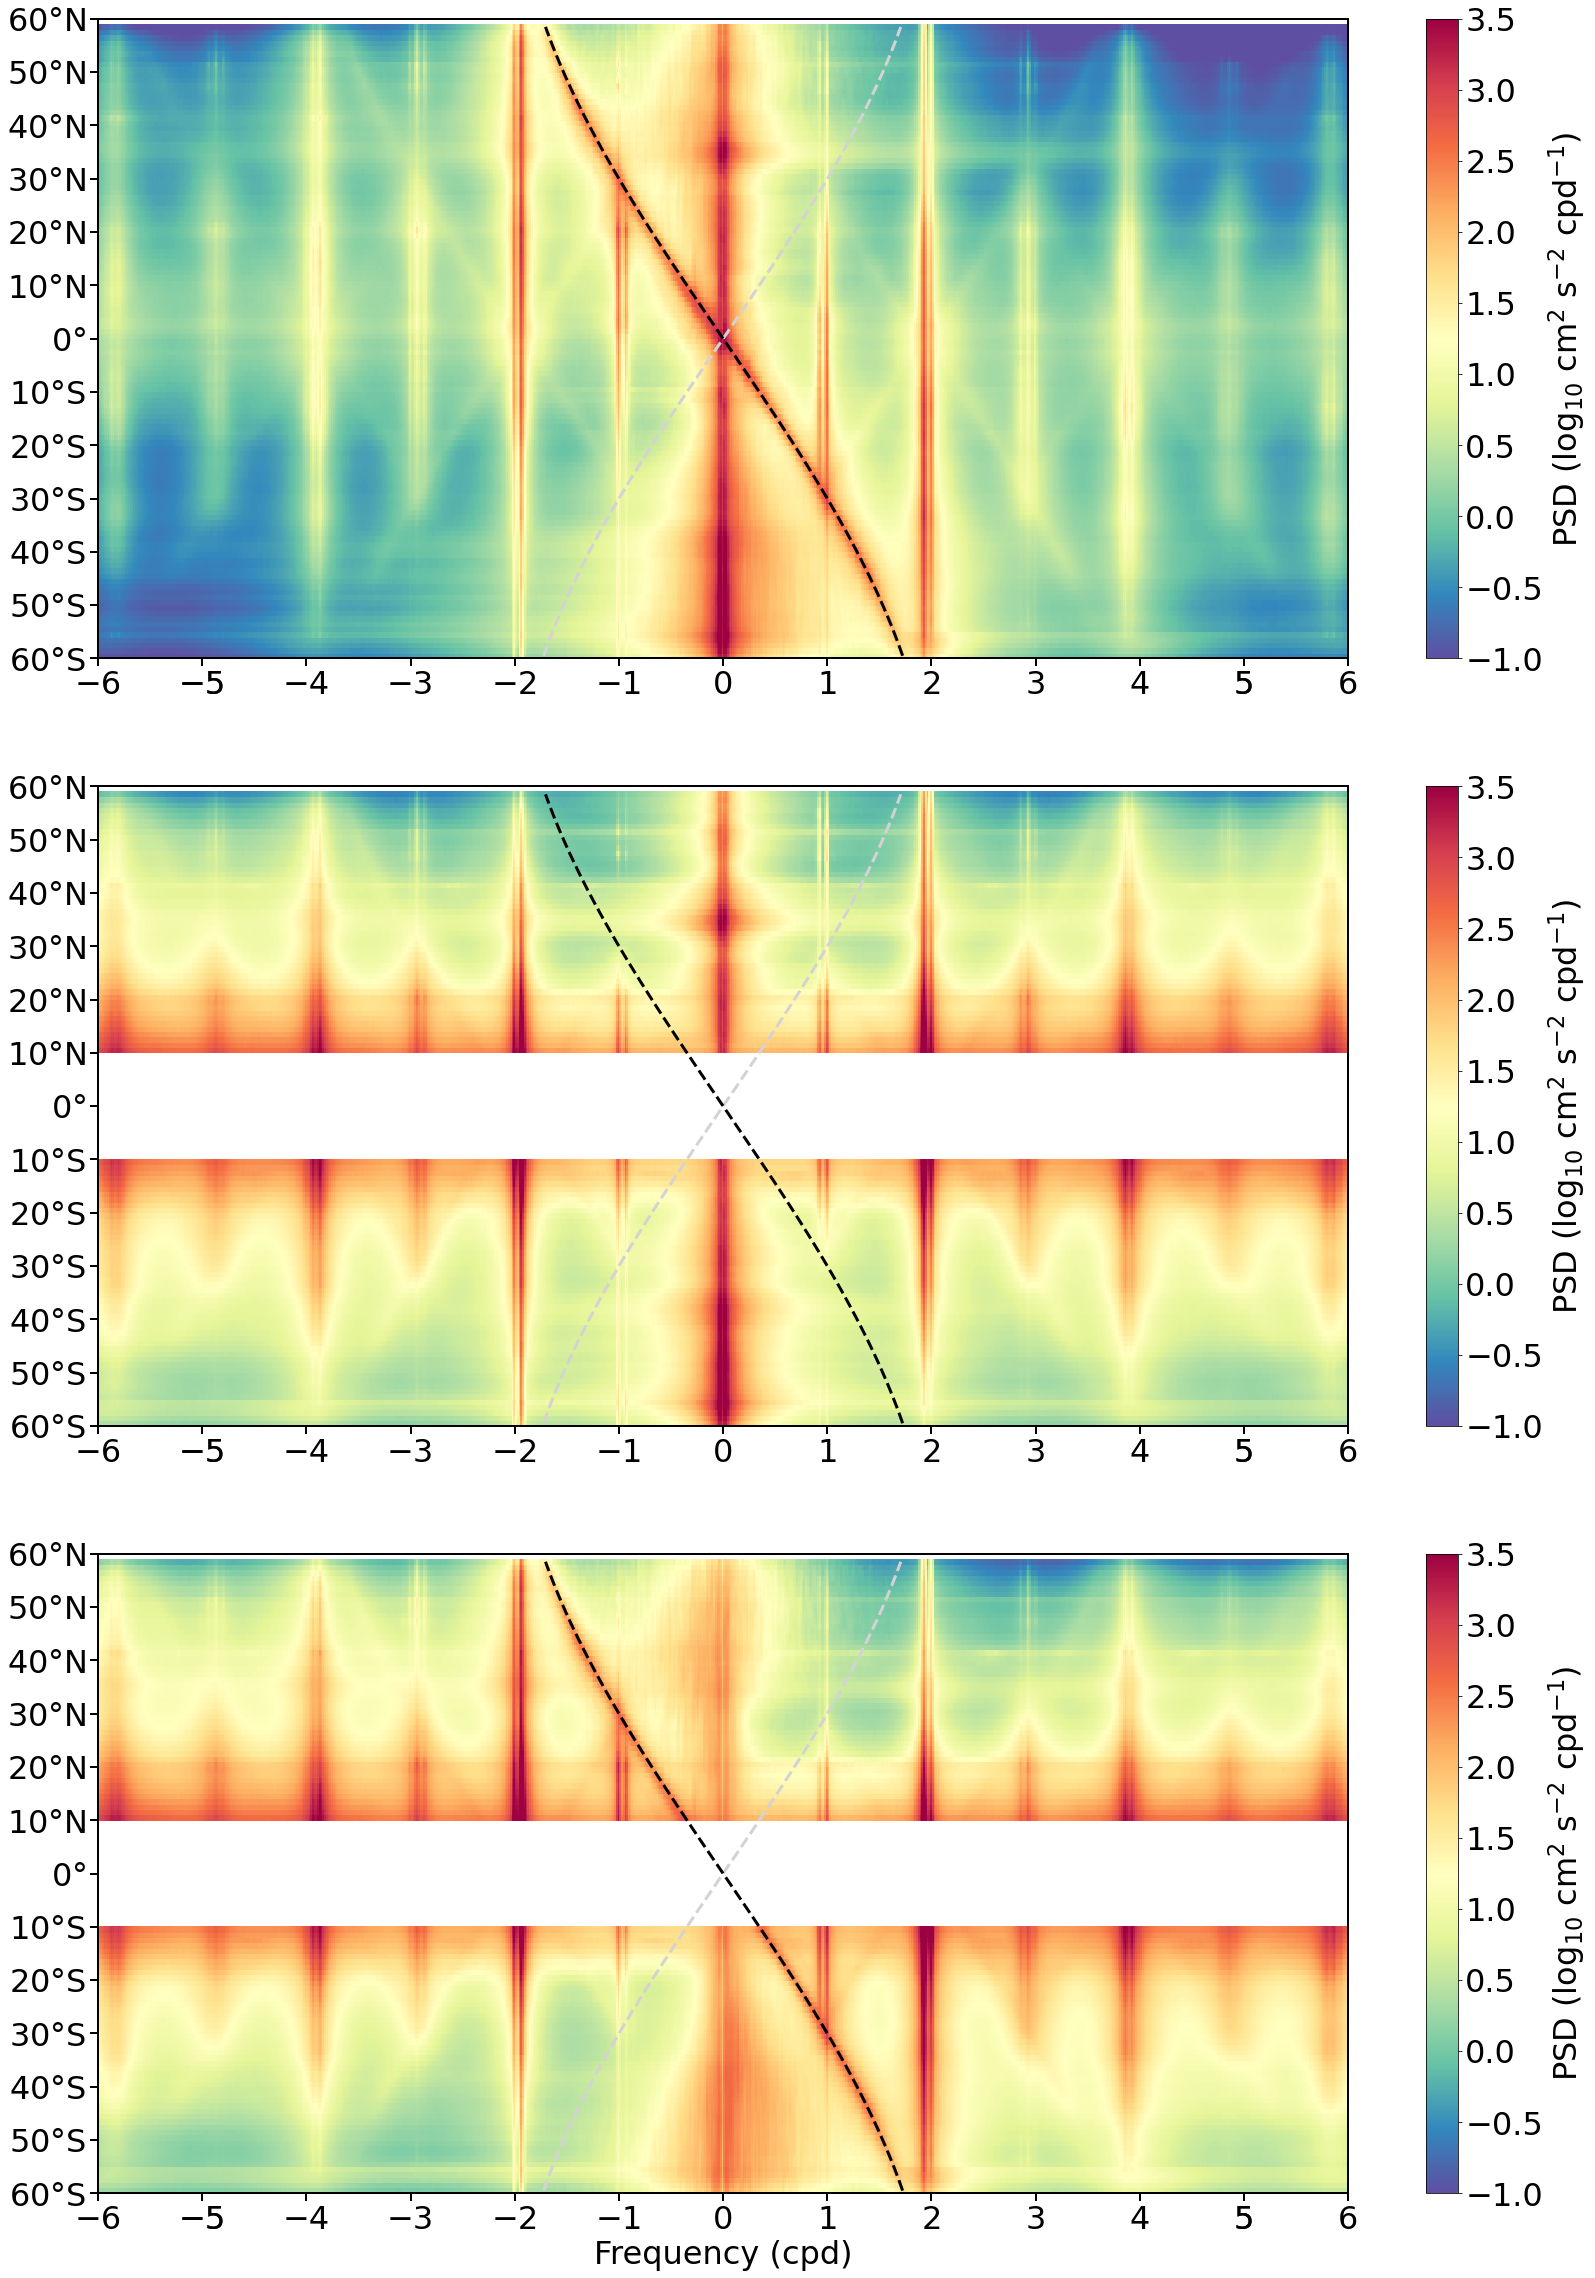

In [9]:
equator = 10
font_size = 32
fig, ax = plt.subplots(figsize=(28,40))

ax = plt.subplot(311)
cax=np.log10(E_total_zav*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-6.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,6.])
ax.set_xlim(-6., 6.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_title('',fontsize=40)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
# add coriolis frequency
ax.plot(f*86400./2./np.pi,f.latitude,'--',color='lightgrey',linewidth=3)
ax.plot(-f*86400./2./np.pi,f.latitude,'--',color='black',linewidth=3)
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
ax = plt.subplot(312)
cax=np.log10(E_geo_zav.where(np.abs(E_total_zav.latitude)>equator)*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-6.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,6.])
ax.set_xlim(-6., 6.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_title('',fontsize=40)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.plot(f*86400./2./np.pi,f.latitude,'--',color='lightgrey',linewidth=3)
ax.plot(-f*86400./2./np.pi,f.latitude,'--',color='black',linewidth=3)
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
ax = plt.subplot(313)
cax=np.log10(E_ageo_zav.where(np.abs(E_total_zav.latitude)>equator)*86400/6).plot(vmin=-1, vmax=3.5, x='freq_time', y='latitude', cmap='Spectral_r', add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD (log$_{10}$ cm$^2$ s$^{-2}$ cpd$^{-1}$)', fontsize=font_size)
ax.set_xticks(list(ax.get_xticks()) + [-6.,-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.,6.])
ax.set_xlim(-6., 6.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_title('',fontsize=40)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
# add coriolis frequency
ax.plot(f*86400./2./np.pi,f.latitude,'--',color='lightgrey',linewidth=3)
ax.plot(-f*86400./2./np.pi,f.latitude,'--',color='black',linewidth=3)
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    
plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_04_dpi300.png',dpi=300)

In [15]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'uv_ageo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/Ageo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_ageo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_ageo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [16]:
F = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
v = 'uv_geo'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/geo_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_geo_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_geo_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [17]:
v = 'uv'
ds_zav = xr.concat([xr.open_zarr(work_data_dir+'xy/total_uv/%s_f%02d_zav.zarr'%(v,face))
                    for face in F], dim='face', compat='identical').sum('face')
E_total_zav = (ds_zav.S_SSUV/ds_zav.W_SSUV).rename('E_SSUV')
print(E_total_zav)

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5


In [18]:
import matplotlib.colors as colors

bounds = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=5)
print(norm)

In [19]:
E_ageo_zav

<xarray.DataArray 'E_SSUV' (freq_time: 1440, latitude: 119)>
dask.array<truediv, shape=(1440, 119), dtype=float64, chunksize=(1440, 119), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * latitude   (latitude) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5

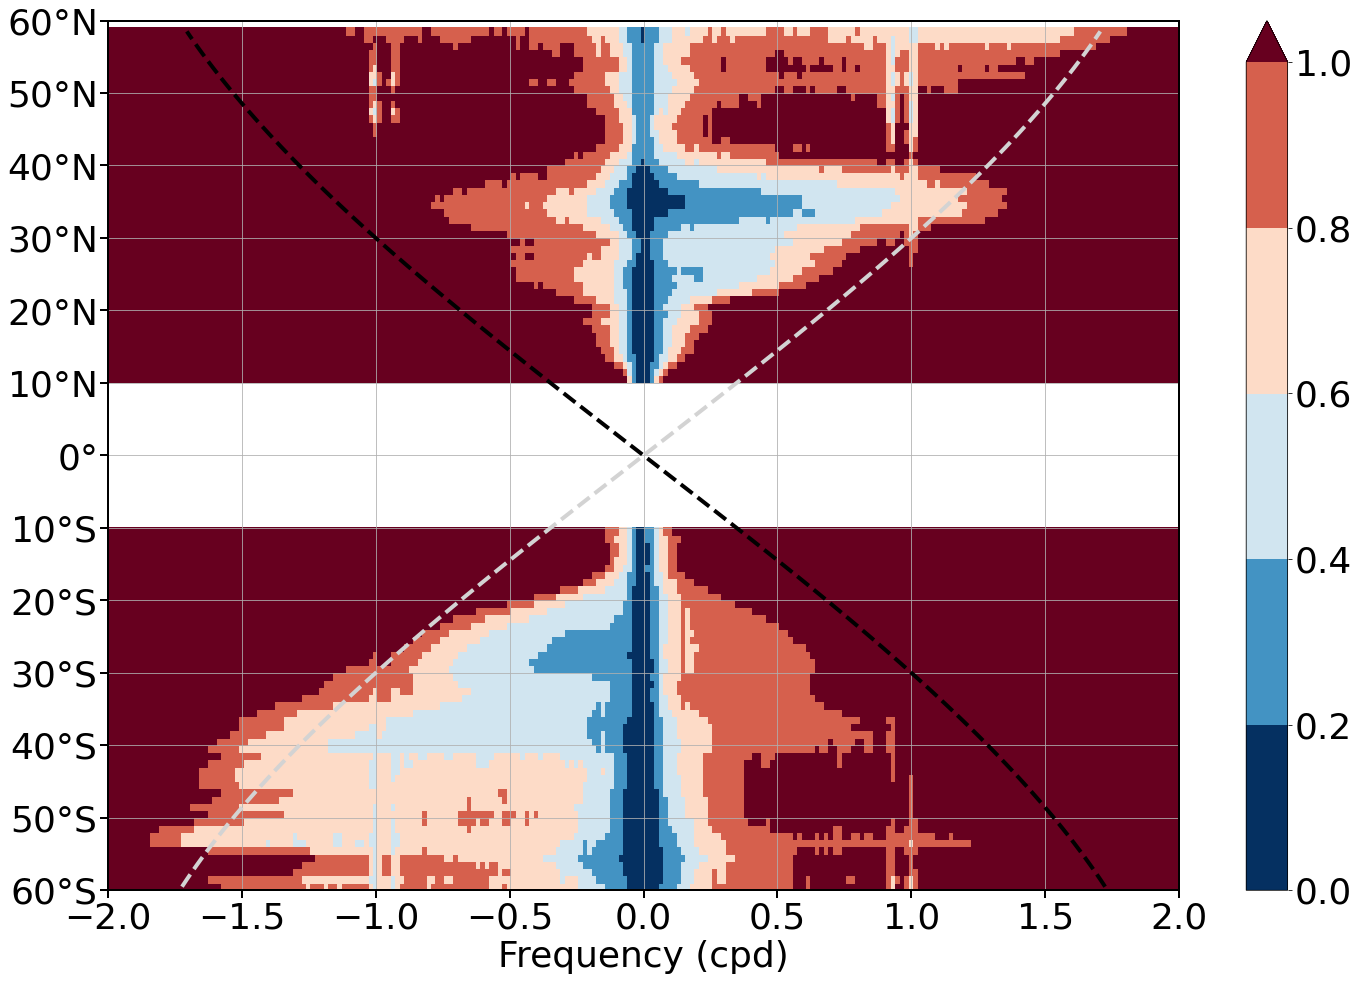

In [25]:
equator = 10
font_size = 36
fig, ax = plt.subplots(figsize=(24,16))

ax = plt.subplot(111)
cax=(E_ageo_zav/E_total_zav.where(np.abs(E_total_zav.latitude)>equator)).plot(vmin=0, vmax=1, x='freq_time', y='latitude',cmap=plt.cm.get_cmap('RdBu_r', 6), add_colorbar = False, norm=norm)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], extend='max')
ax.grid()
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('', fontsize=font_size)
ax.set_xlim(-2., 2.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_title('',fontsize=40)
ax.tick_params(labelsize=font_size,length=10)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

ax.plot(f*86400./2./np.pi,f.latitude,'--',color='lightgrey',linewidth=4)
ax.plot(-f*86400./2./np.pi,f.latitude,'--',color='black',linewidth=4)

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_07a.png')

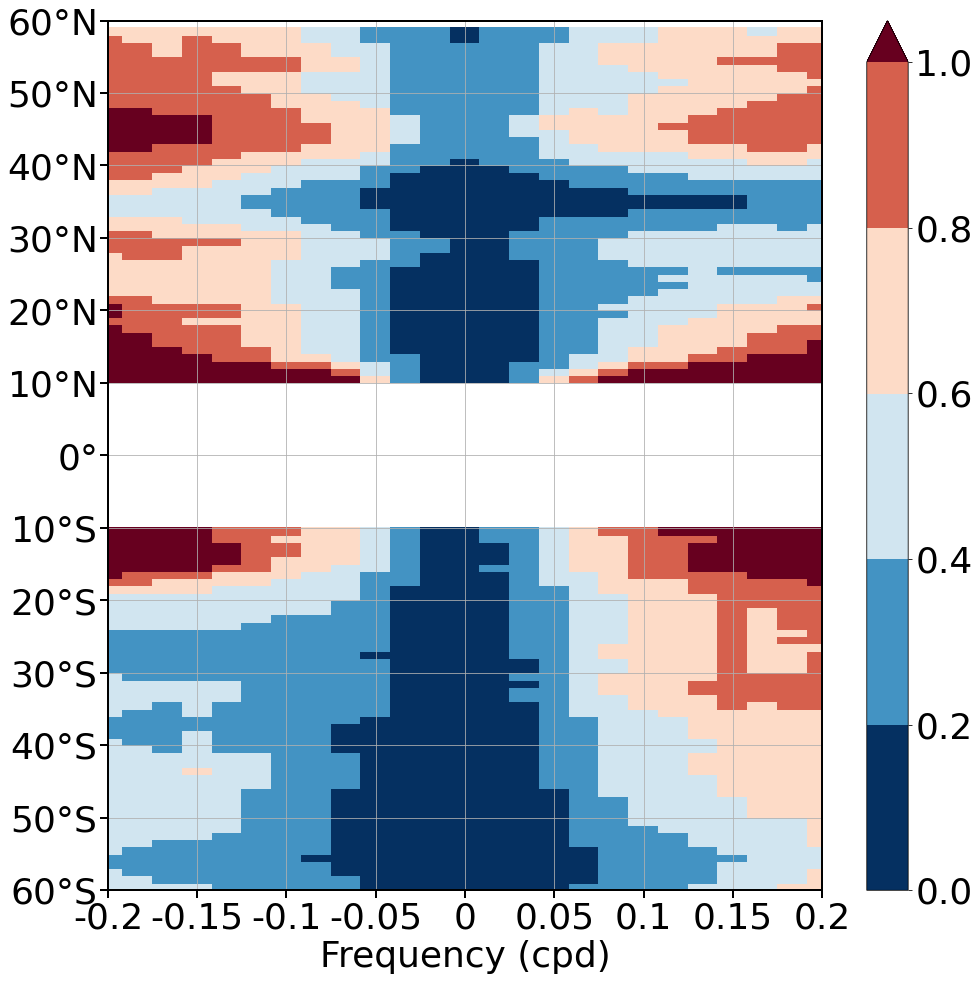

In [26]:
font_size = 36
fig, ax = plt.subplots(figsize=(16,16))

ax = plt.subplot(111)
cax=(E_ageo_zav/E_total_zav.where(np.abs(E_total_zav.latitude)>equator)).plot(vmin=0, vmax=1, x='freq_time', y='latitude',cmap=plt.cm.get_cmap('RdBu_r', 6), add_colorbar = False, norm=norm)
cbar = plt.colorbar(cax, ax=ax,orientation='vertical', ticks=[0, 0.2, 0.4, 0.6, 0.8, 1], extend='max')
ax.grid()
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('', fontsize=font_size)
ax.set_xlim(-0.2, 0.2)
ax.set_ylim(-60., 60.)
ax.set_xticks(np.arange(-0.2,0.21,0.05)) 
ax.set_xticklabels(['-0.2','-0.15','-0.1','-0.05','0','0.05','0.1','0.15','0.2'])
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','$50\degree$S','$40\degree$S','$30\degree$S','$20\degree$S','$10\degree$S','$0\degree$','$10\degree$N','$20\degree$N','$30\degree$N','$40\degree$N','$50\degree$N','$60\degree$N'])
ax.set_title('',fontsize=40)
ax.tick_params(labelsize=font_size,length=10)
ax.set_ylabel('',fontsize=font_size)
ax.tick_params(direction='out', length=8, width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)

plt.savefig('/home/uz/yux/mit_equinox_backup/hal/Geostrophy_assessment/Figures/Figure_07b.png')

In [12]:
cluster.close()